In [28]:
import utils.scraping as scraping
import utils.stat as stat

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [41]:
data = scraping.get_results("https://bases.athle.fr/asp.net/liste.aspx?frmbase=resultats&frmmode=1&frmespace=0&frmcompetition=282742", 13)

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3248 entries, 0 to 3247
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype          
---  ------       --------------  -----          
 0   Athlète      3248 non-null   object         
 1   Ligue        3248 non-null   object         
 2   Performance  3248 non-null   object         
 3   Naissance    3248 non-null   object         
 4   Catégorie    3211 non-null   object         
 5   hours        3248 non-null   int32          
 6   minutes      3248 non-null   int32          
 7   seconds      3248 non-null   int32          
 8   time_delta   3248 non-null   timedelta64[ns]
 9   time_gap     3248 non-null   timedelta64[ns]
 10  duration     3248 non-null   float64        
dtypes: float64(1), int32(3), object(5), timedelta64[ns](2)
memory usage: 241.2+ KB


In [43]:
data.head()

,Athlète,Ligue,Performance,Naissance,Catégorie,hours,minutes,seconds,time_delta,time_gap,duration
0,NIYAKUNDI Dickson Simba,0,N1,1995,SEM,0,28,45,0 days 00:28:45,0 days 00:00:00,1725.0
1,MARQUANT Antonin,H-F,N2,2002,ESM,0,29,2,0 days 00:29:02,0 days 00:00:17,1742.0
2,KOECH Isaac,NOR,N2,1989,M0M,0,29,13,0 days 00:29:13,0 days 00:00:28,1753.0
3,TOUATI Clement,H-F,N2,2000,SEM,0,29,18,0 days 00:29:18,0 days 00:00:33,1758.0
4,WITZ Valentin,G-E,N2,1993,SEM,0,29,43,0 days 00:29:43,0 days 00:00:58,1783.0


In [44]:
data.tail()

,Athlète,Ligue,Performance,Naissance,Catégorie,hours,minutes,seconds,time_delta,time_gap,duration
3243,SCHIPMAN Johannie,0,,1983,SEF,1,11,59,0 days 01:11:59,0 days 00:43:14,4319.0
3244,DHAUSSY Emeline,0,,1999,M0F,1,12,1,0 days 01:12:01,0 days 00:43:16,4321.0
3245,FROMENT Annick,0,,1989,ESF,1,12,1,0 days 01:12:01,0 days 00:43:16,4321.0
3246,ORSZULAK Delphine,0,,1995,SEM,1,12,1,0 days 01:12:01,0 days 00:43:16,4321.0
3247,LOCUSOLLE Emeline,0,,2003,M0M,1,12,2,0 days 01:12:02,0 days 00:43:17,4322.0


In [45]:
data['Prénom'] = data['Athlète'].str.extract('[A-Z]+(?:[- ]?[A-Z]+)? (.+)')
data['Nom'] = data.apply(lambda row: row['Athlète'].replace(row['Prénom'], ''), axis=1)
data['h_duration'] = data['duration'].apply(lambda x : pd.to_datetime(x,unit="s").strftime('%H:%M:%S'))

In [46]:
def truncf (f,xmin, xmax):
    def f2 (x):
        if (x>=xmin)*(x<=xmax):
            return f(x)
        return np.nan
    
    return np.vectorize(f2)

In [47]:
def graphePerso(prenom, nom, data, titre):
    
    densite=stat.dens(data['duration'], bins = stat.idealBins(len(data['duration']))) #Calcul de la densité de la variable 'duration'
    #print(densite)
    fcubic=stat.lissage(densite, sep = True,beginend = (data['duration'].min(),data['duration'].max())) #Retourne la fonction d'interpolation cubique
    flin=stat.lissage(densite, sep = False, kind = 'linear', beginend = (data['duration'].min(),data['duration'].max())) #Retourne la fonction d'interpolation linéaire
    
    z=data.index[data.Athlète==(nom.upper()+" "+prenom.capitalize())] #numéro de l'index du participant
    
    temps = data.loc[z[0],'duration'] #temps du participant
    
    x= np.linspace(data['duration'].min(),data['duration'].max(), int(1e5)) #x permet d'obtenir un tracé continu

    tempsAxe = np.linspace(densite[0,0],densite[0,-1],6) #définition de l'axe des abscisses en secondes avec 6 points
    labelTempsAxe = pd.Series(tempsAxe).apply(lambda x : pd.to_datetime(x,unit="s").strftime('%H:%M:%S')) #Définition de la forme que prendra le temps sur l'axe des abcisses (format heures/minutes/secondes pour plus de lisibilité)

    plt.figure(figsize=(8,4.5), dpi=80) #format de la figure, (dpi pour la résolution)
    plt.fill_between(x, fcubic(x), alpha = 0.3) #fonction pour colorier l'aire sous la courbe
    plt.plot(x, fcubic(x), color = 'blue', label = 'densité lissée & interpolée')

    #plt.plot(x,flin(x), linestyle ='--', color = 'black', label = "densité réelle") #possibilité de dessiner l'interpolation linéaire au lieu de l'interpolation cubique

    plt.axvline(temps, color='r',alpha=0.3) #ligne verticale pour indiquer la position du participant sur les abscisses

    f2=truncf(fcubic,data['duration'].min(), temps) #on tronque fcubic pour ne retenir que la partie de la fonction des temps meilleurs à celui de l'individu
    plt.fill_between(x,f2(x), alpha = 0.6, color = 'red') #on affiche l'aire des temps meilleurs à celui de l'individu en rouge

    #plt.axvspan(temps, densite[0,0], color='r', alpha=0.3)
    plt.legend() #permet d'afficher les légendes qu'on a mises dans les arguments 'label' des fonctions juste au dessus

    # Ajout des labels et titre
    plt.title(titre, color= 'tab:red', fontsize = '15', fontstyle = 'oblique') # titre
    plt.xlabel("Durée pour franchir la ligne d'arrivée", fontstyle = 'italic', labelpad=5) #label abscisse
    plt.ylabel("Densité des athlètes", fontstyle = 'italic', labelpad=20) #label ordonnée
    plt.xticks(tempsAxe,labels = labelTempsAxe) #permet de choisir ce qu'on met sur l'axe des x : les coordonnées dans le premier argument, ce qu'il faut afficher dans le second.
    plt.ylim((-0.1*max(densite[1]),1.1*max(densite[1]))) #permet de choisir l'espace au dessus et au dessous du graphe
    plt.text(data.loc[z[0],'duration'],0.0001,data.loc[z[0],'Prénom'] ) # ajoute un texte directement sur le graphe
    plt.show()
    return

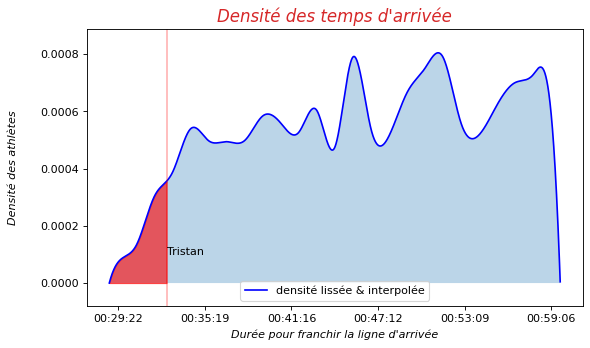

In [40]:
graphePerso("tristan","kirscher", data=data,titre = "Densité des temps d'arrivée")

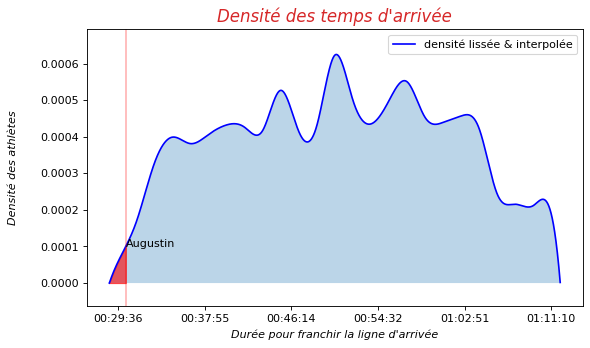

In [48]:
graphePerso("augustin","cablant", data=data,titre = "Densité des temps d'arrivée")